In [5]:
pip install fastai -U

     |████████████████████████████████| 358kB 5.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [6]:
pip install nbdev

     |████████████████████████████████| 61kB 2.9MB/s 


In [3]:
import fastai
fastai.__version__

'2.0.10'

In [4]:
from fastai.vision.all import *

In [5]:
path = untar_data(URLs.PASCAL_2007)

In [6]:
Path.BASE_PATH = path

In [7]:
path.ls()

(#8) [Path('train.json'),Path('test.json'),Path('valid.json'),Path('train'),Path('test.csv'),Path('segmentation'),Path('train.csv'),Path('test')]

In [8]:
df = pd.read_csv(path / 'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [9]:
dblock = DataBlock()

In [10]:
dsets = dblock.datasets(df)

In [11]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [12]:
x,y = dsets.train[0]

In [13]:
x,y

(fname       000804.jpg
 labels      chair sofa
 is_valid         False
 Name: 392, dtype: object, fname       000804.jpg
 labels      chair sofa
 is_valid         False
 Name: 392, dtype: object)

In [14]:
x['fname']

'000804.jpg'

In [15]:
dblock = DataBlock(get_x = lambda x: x['fname'], get_y = lambda x: x['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('007571.jpg', 'person bicycle')

In [16]:
def get_x(x): return x['fname']
def get_y(x): return x['labels']

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('008098.jpg', 'car bus')

In [17]:
def get_x(x): return path / 'train' / x['fname']
def get_y(x): return x['labels'].split()

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.valid[0]

(Path('train/005131.jpg'), ['cat'])

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y)
dsets = dblock.datasets(df)
dsets.valid[0]

(PILImage mode=RGB size=500x332,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0.]))

In [19]:
idx = torch.where(dsets.valid[0][1]==1.)[0]
dsets.valid.vocab[idx]

(#2) ['motorbike','person']

In [20]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    get_x=get_x,
                    get_y=get_y,
                    splitter=splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [21]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

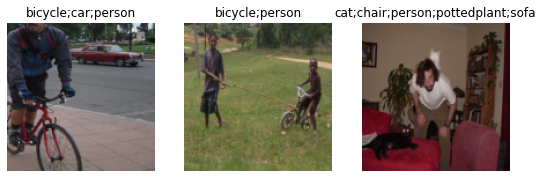

In [22]:
dls.show_batch(max_n=3, nrows=1)

In [23]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [25]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [26]:
activs[0]

tensor([ 0.6330,  1.1309,  0.2289,  0.7915,  5.2336, -1.2376, -0.3562,  0.4971,
         1.3937,  1.0107, -0.9207, -0.8108,  1.0490,  2.8448, -0.3339, -3.2641,
         0.1700, -2.0234, -0.3645, -0.0188], grad_fn=<SelectBackward>)

In [27]:
def binary_cross_entropy(inputs, targets):
    acts = inputs.sigmoid()
    return -torch.where(targets == 1, acts, 1-acts).log().mean()


In [28]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss 

tensor(1.0419, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [29]:
def accuracy_multi(inp, targ, thres=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp > thres)== targ.bool()).float().mean()

In [30]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}"
say_hello('Jeremy'), say_hello("Jeremy", 'Ahoy!')

('Hello Jeremy', 'Ahoy! Jeremy')

In [31]:
f = partial(say_hello, say_what='Bonjour')

In [32]:
f('Jeremy')

'Bonjour Jeremy'

In [33]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thres=0.2))
learn.fine_tune(3, 3e-2, 4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.749917,0.373119,0.515498,00:34
1,0.369310,0.131183,0.940677,00:34
2,0.228256,0.130607,0.938546,00:34
3,0.172607,0.127599,0.941793,00:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.175970,0.439404,0.914542,00:34
1,0.176370,0.155732,0.916255,00:34
2,0.149458,0.130401,0.932729,00:34


In [34]:
preds, targs = learn.get_preds()

In [38]:
accuracy_multi(preds, targs, thres=0.9, sigmoid=False)

tensor(0.9427)

Text(0.5, 1.0, 'Accuracy at different thresholds')

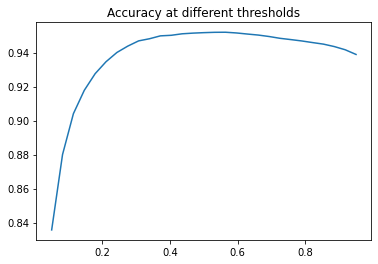

In [40]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thres=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)
plt.title("Accuracy at different thresholds")

###Regression

In [42]:
from fastai.data.all import *

In [19]:

from fastai.vision.all import * 
path = untar_data(URLs.BIWI_HEAD_POSE)

In [21]:
Path.BASE_PATH = path

In [22]:
path

Path('.')

In [9]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [10]:
(path / "01").ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [11]:
img_files = get_image_files(path)
def img2pose(x): return Path(f"{str(x)[:-7]}pose.txt")
img2pose(img_files[0])

Path('13/frame_00010_pose.txt')

In [12]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

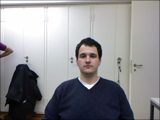

In [13]:
im.to_thumb(160)

In [23]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [29]:
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [27]:
get_ctr(img_files[0])

tensor([360.9309, 236.5820])

In [28]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)),
                             Normalize.from_stats(*imagenet_stats)])


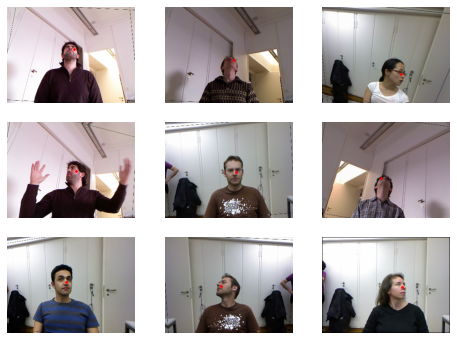

In [31]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [33]:
xb, yb = dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [36]:
yb[0]

tensor([[ 0.0937, -0.1197]], device='cuda:0')

In [38]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1));

In [39]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [52]:
pip install utils

In [59]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.03981071710586548)

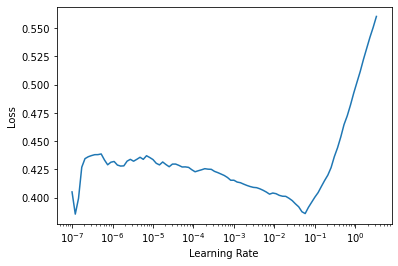

In [67]:
learn.lr_find()

In [68]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.050038,0.013470,01:55


epoch,train_loss,valid_loss,time
0,0.008734,0.000766,02:02
1,0.003287,0.000322,02:05
2,0.001387,0.000049,02:04


In [ ]:
def sigmoid_range(x, low, high): return torch.sigmoid(x) * (hi - low) + low

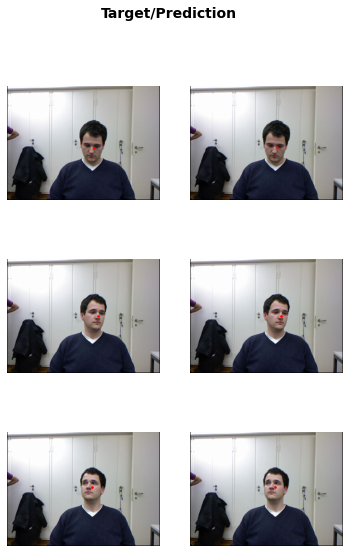

In [70]:
learn.show_results(ds_idx=1, nrows=3)